# Project Proposal
Group 60 - Danyal, Ruth, Thomas, Paul

# Predicting the presence of heart disease based on data

## Introduction

   Heart disease commonly refers to reduced blood flow to the heart due to narrowed vessels. The most common heart disease is known as Coronary Artery Disease (CAD) where cholesterol deposits of plaque build up in the wall of the arteries [1]. When the heart does not receive enough oxygen-rich blood, it becomes deprived of nutrients and reduces its ability to pump blood out of the aorta. Symptoms of reduced blood flow may lead to shortness of breath, chest pain, and eventually heart attacks [2]. Therefore, the question we can formulate is: **Can we use the heart disease data containing the different attributes of each patient to predict whether a future patient with certain attributes shows a diameter narrowing of <50% or >50%?**
   
   The heart dataset we will be using to explore this question is a multivariate data set with 75 attributes. Out of those 75, we have chosen 13 attributes that will be the predictors for the classification of the last attribute. The last attribute will predict a value of 0 or 1 where Value 0: < 50% diameter narrowing and Value 1: > 50% diameter narrowing

## Preliminary exploratory data analysis

In [1]:
# Setup
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 8, repr.plot.height = 7)
set.seed(9248)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Obtain data from external source and combine into one table
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
types <- "nnnnnnnnnnnnnn"
cleveland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                      col_names = names, col_types = types) |>
    mutate(location = "Cleveland")
hungary <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
                    col_names = names, col_types = types) |>
    mutate(location = "Hungary")
switzerland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                        col_names = names, col_types = types) |>
    mutate(location = "Switzerland")
longbeach <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                      col_names = names, col_types = types) |>
    mutate(location = "Long Beach")
complete <- bind_rows(cleveland, hungary, switzerland, longbeach)

# Clean data
heart_disease <- complete |>
    mutate(sex = as_factor(ifelse(sex == 1, "male", "female")),
           cp = as_factor(cp),
           trestbps = ifelse(trestbps == 0, NA, trestbps),
           chol = ifelse(chol == 0, NA, chol),
           fbs = as.logical(fbs),
           restecg = as_factor(restecg),
           exang = as.logical(exang),
           slope = as_factor(slope),
           thal = as_factor(thal),
           disease = num != 0,
           location = as_factor(location)) |>
    select(-num)
heart_disease

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,location,disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<fct>,<dbl>,<lgl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<lgl>
63,male,1,145,233,TRUE,2,150,FALSE,2.3,3,0,6,Cleveland,FALSE
67,male,4,160,286,FALSE,2,108,TRUE,1.5,2,3,3,Cleveland,TRUE
67,male,4,120,229,FALSE,2,129,TRUE,2.6,2,2,7,Cleveland,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,male,4,122,223,TRUE,1,100,FALSE,0,NA,NA,6,Long Beach,TRUE
58,male,4,NA,385,TRUE,2,NA,NA,NA,NA,NA,NA,Long Beach,FALSE
62,male,2,120,254,FALSE,2,93,TRUE,0,NA,NA,NA,Long Beach,TRUE


In [3]:
# Training/testing split
heart_split <- initial_split(heart_disease, prop = 0.75, strata = disease, location)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [4]:
# Count rows in each column with missing data
heart_missing <- heart_training |>
    map_df(function(x) sum(is.na(x)))
heart_missing

# Number of observations with and without heart disease from each location
disease_count <- heart_training |>
    group_by(location, disease) |>
    summarize(count = n()) |>
    pivot_wider(names_from = disease, values_from = count)
disease_count

# Select only columns with numeric data and calculate mean of each column
heart_mean <- heart_training |>
    select(age, trestbps, chol, thalach, oldpeak, ca) |>
    map_df(mean, na.rm = TRUE)
heart_mean

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,location,disease
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,45,153,68,1,40,40,43,219,449,353,0,0


`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


location,FALSE,TRUE
<fct>,<int>,<int>
Cleveland,125,110
Hungary,136,79
Switzerland,7,87
Long Beach,40,105


age,trestbps,chol,thalach,oldpeak,ca
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53.40348,132.1801,246.0578,138.7442,0.9113003,0.625


Warning message:
“Removed 45 rows containing missing values (geom_point).”
Warning message:
“Removed 153 rows containing missing values (geom_point).”


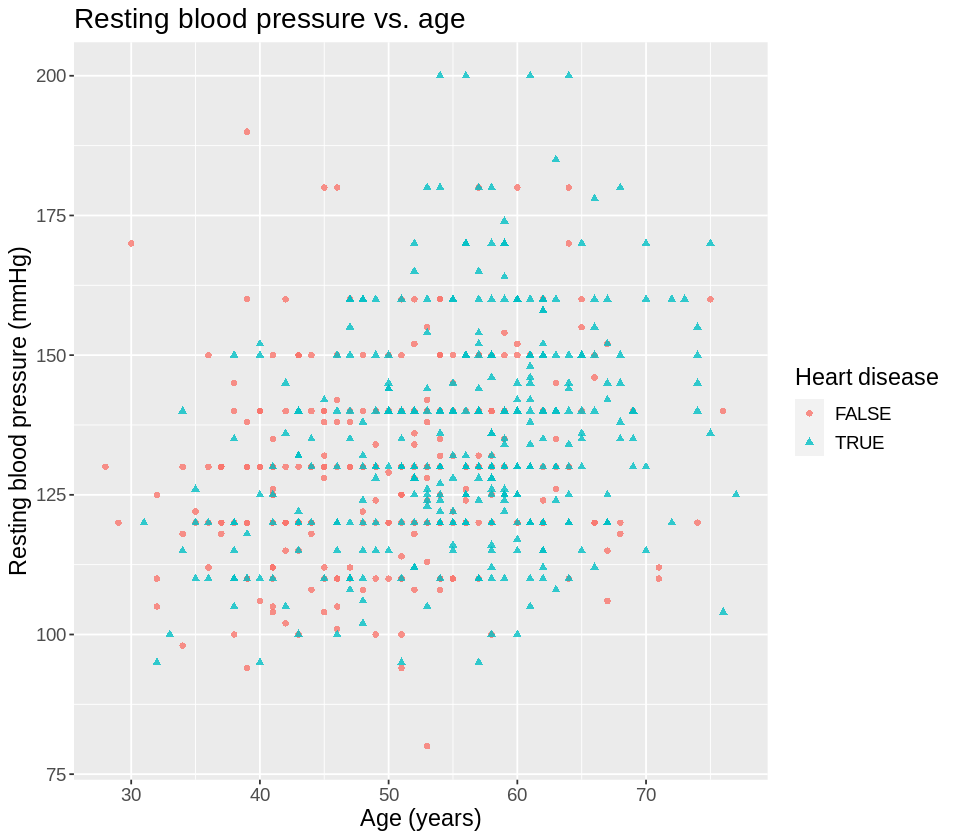

Warning message:
“Removed 44 rows containing missing values (geom_point).”


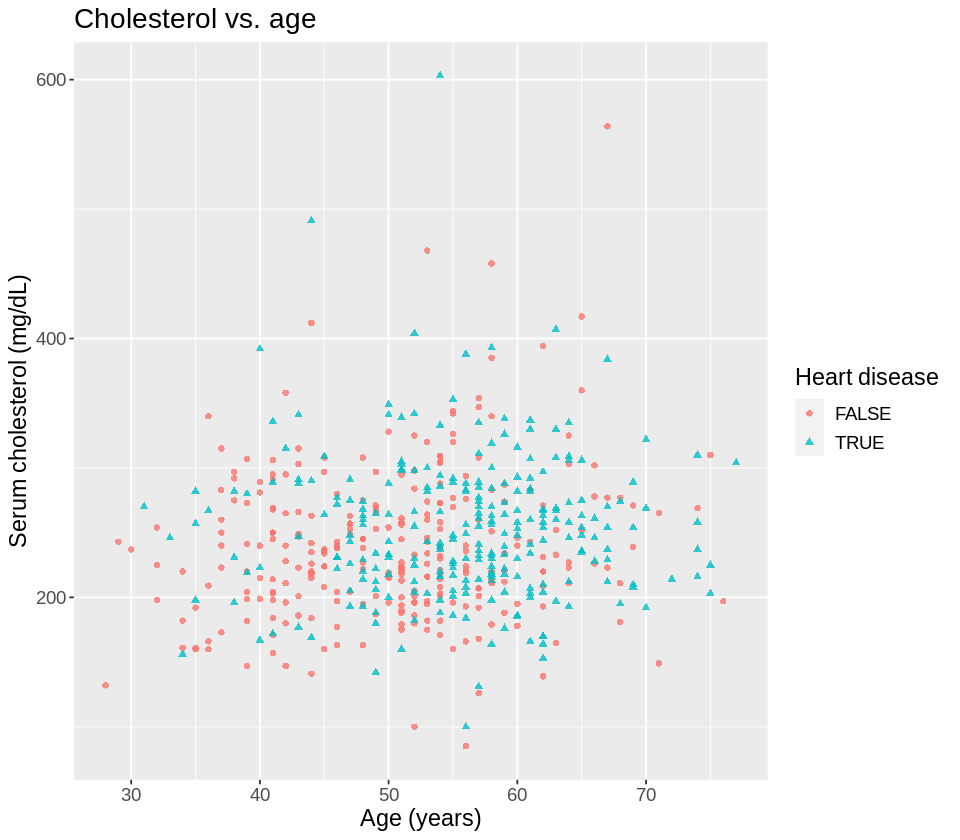

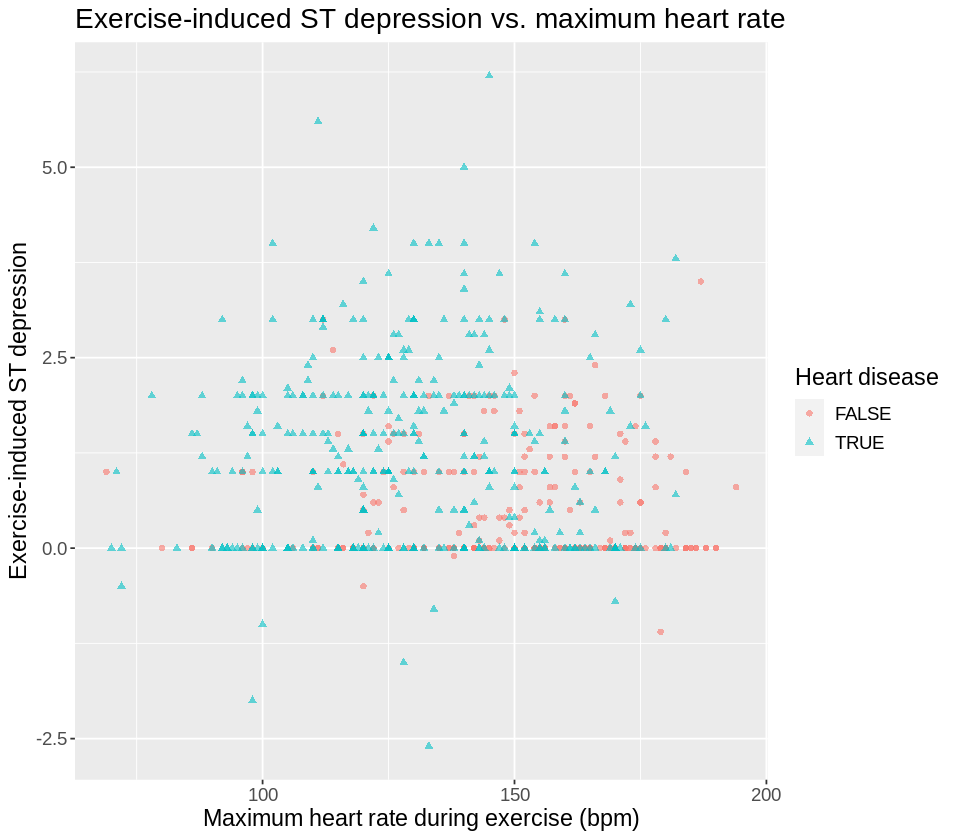

In [5]:
# Initial visualizations
thalach_vs_age <- heart_training |>
    ggplot(aes(x = age, y = trestbps, colour = disease, shape = disease)) +
        geom_point(alpha = 0.8) +
        labs(title = "Resting blood pressure vs. age", x = "Age (years)", y = "Resting blood pressure (mmHg)", colour = "Heart disease", shape = "Heart disease") +
        theme(text = element_text(size = 14))
thalach_vs_age
chol_vs_age <- heart_training |>
    ggplot(aes(x = age, y = chol, colour = disease, shape = disease)) +
        geom_point(alpha = 0.8) +
        labs(title = "Cholesterol vs. age", x = "Age (years)", y = "Serum cholesterol (mg/dL)", colour = "Heart disease", shape = "Heart disease") +
        theme(text = element_text(size = 14))
chol_vs_age
oldpeak_vs_thalach <- heart_training |>
    ggplot(aes(x = thalach, y = oldpeak, colour = disease, shape = disease)) +
        geom_point(alpha = 0.6) +
        labs(title = "Exercise-induced ST depression vs. maximum heart rate", x = "Maximum heart rate during exercise (bpm)", y = "Exercise-induced ST depression", colour = "Heart disease", shape = "Heart disease") +
        theme(text = element_text(size = 14))
oldpeak_vs_thalach

## Methods

Our first iteration of predictor will use k-nearst neighbors to predict whether a patient has heart disease using data from the numerical categories:
- age
- trestbps (the patient's resting blood pressure, in mm Hg)
- chol (the patient's cholesterol levels, in mg/dl)
- thalach (the patient's maximum heart rate, in bpm)
- oldpeak (the difference between ST depression during exercise and at rest. ST depression is the drop in electric pulse on a cardiogram that occurs after a heartbeat. The units for this measurement are unpecified)

In [37]:
# Select only columns with numeric data and calculate the mean of values in each column of patients with heart disease,
# and the mean of values in each column of patients without heart disease
mean_diff <- heart_training |>
    select(age, trestbps, chol, thalach, oldpeak, disease) |>
    pivot_longer(cols = age:oldpeak, names_to = "category", values_to = "value") |>
    filter(!is.na(value)) |>
    group_by(disease, category) |>
    summarize(avg = mean(value)) |>
    pivot_wider(names_from = category, values_from = avg)
print("Average values with and without heart disease for each category")
mean_diff

`summarise()` has grouped output by 'disease'. You can override using the
`.groups` argument.


[1] "Average values with and without heart disease for each category"


disease,age,chol,oldpeak,thalach,trestbps
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,50.59740,239.5647,0.4670103,149.5876,129.4983
TRUE,55.67192,253.0543,1.2754930,129.9302,134.3909


As we can see by the table above, the average value for our variables differ, depending on whether the patient has heart disease. It is shown that heart disease is more common in four out of five of these categories. Further, our data show that the average for these values is higher in patients with heart disease than without. One exception would be that patients with lower averages of max heart rate have heart disease compared to patients without. While these averages are not useful for making statistical conclusions, the fact that the values match our expectations by differing between patients with and without heart disease indicates that these variables could be good to use in our classification model.

In future iterations of our predictor, it might also be useful to take into account a select categorical variable. Certain categorical variables, such as the type of chest pain experienced by a patient, or whether the patient has high blood sugar, could also be useful in predicting. One way to incorporate these variables into our prediction would be to separate our training data by category and then train different models for each category.

To analyze and compare the results of various iterations of models, we will visualize the performance of our model using a confusion matrix. The confusion matrix is the ideal tool for this job because it will allow us to easily identify false negatives and false positives. In diagnosing heart disease, a false negative, where a classifier predicts that a patient does not have heart disease when in fact they do, could have severe consequences. Thus, using a confusion matrix to understand how often the model makes such wrong predictions is very important. 

## Expected outcomes and significance

We expect to find our predictor classifying patients with poor health conditions such as older age and high cholesterol to have higher chances of heart disease. Such findings would have a monumental effect on healthcare systems. It would allow medical workers to have a more accurate predictor of heart disease in apatients. With this knowledge, preventive care can be administered and heart disease may be tackled before it sets in. Patients with higher chances can be monitored closely. This system could lead to questions such as ‘what are the chances of the predictor having anomalous results? Due to the nature of healthcare, such systems are always under enormous scrutiny. More questions that could be asked could be related to adapting this system for diseases other than heart disease. Further, the most monumental question is the impact/ethical responsibilities of a wrongful diagnosis of a patient. 

Footnotes

[1]https://www.cdc.gov/heartdisease/about.htm#:~:text=The%20term%20%E2%80%9Cheart%20disease%E2%80%9D%20refers,can%20cause%20a%20heart%20attack.
[2] https://www.mayoclinic.org/diseases-conditions/coronary-artery-disease/symptoms-causes/syc-20350613#:~:text=Signs%20and%20symptoms%20of%20coronary,can%20cause%20a%20heart%20attack.